In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import xarray as xr
import psutil
from dask.distributed import Client, LocalCluster
import logging

import tools

# the autoreload magic command above makes changes to dev functions put in tools.py 
# immmidiately available in the notebook without restarting the kernel.

# relevant functions put in tools.py can be transferred to a common or upstream library 
# later on during the hackweek.

In [3]:
cluster = LocalCluster(
    n_workers=psutil.cpu_count(logical=True)-1,
    silence_logs=logging.ERROR,
    threads_per_worker=1,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 9
Total threads: 9,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63403,Workers: 9
Dashboard: http://127.0.0.1:8787/status,Total threads: 9
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:63424,Total threads: 1
Dashboard: http://127.0.0.1:63426/status,Memory: 7.11 GiB
Nanny: tcp://127.0.0.1:63406,


## AWS DEM data access

Data access to historical and modern DEMs produced over Mount Baker and South Cascade Glacier in the northern Cascade Range. All DEMs are coregistered to a modern reference DEM, projected on to a common grid, and stacked using the Geospatial Time Series Analaysis ([GTSA](https://github.com/friedrichknuth/gtsa/tree/main)) library.

**Mount Baker** (1947 - 2020)  
**South Cascade Glacier** (1958 - 2021)

The reference DEM for Mount Baker is dated 2015-08-27 and is included in the stack. This DEM is derived from WADNR lidar and provides full spatial coverage. The reference DEM for South Cascade Glacier is a composite 2013-2015 DEM and is not included in the stack. This DEM was used for coregistration purposes only as it provides greater coverage over stable ground.

In [4]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

In [5]:
baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True})
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True})

In [6]:
baker_url = '/Users/knuth/Documents/data/tmp/baker.zarr'
scg_url = '/Users/knuth/Documents/data/tmp/scg.zarr'

baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr')
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr')

### Dataset overview

In [7]:
baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 12089, x: 11383)
Coordinates:
  * time         (time) datetime64[ns] 1947-09-14 1950-09-02 ... 2020-12-12
  * x            (x) float64 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y            (y) float64 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 712, 670), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [8]:
scg_ds

<xarray.Dataset>
Dimensions:      (time: 71, y: 2455, x: 2119)
Coordinates:
  * time         (time) datetime64[ns] 1958-08-13 1967-09-21 ... 2021-08-13
  * x            (x) float64 6.419e+05 6.419e+05 ... 6.461e+05 6.461e+05
  * y            (y) float64 5.36e+06 5.36e+06 5.36e+06 ... 5.356e+06 5.356e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(71, 614, 530), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:      Area
    TIFFTAG_ARTIST:     U.S. Geological Survey Benchmark Glacier Program
    TIFFTAG_COPYRIGHT:  Public Domain
    add_offset:         0.0
    crs:                PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM[...
    scale_factor:       1.0

### Examine spatial and temporal coverage

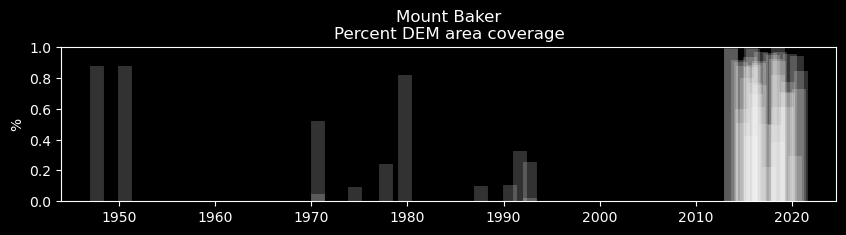

In [7]:
tools.plot_percent_area_coverage(baker_ds, title = 'Mount Baker\nPercent DEM area coverage')

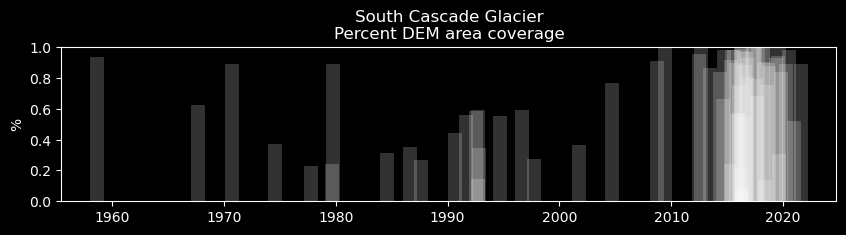

In [8]:
tools.plot_percent_area_coverage(scg_ds, title = 'South Cascade Glacier\nPercent DEM area coverage')

### Plot a time stamp 

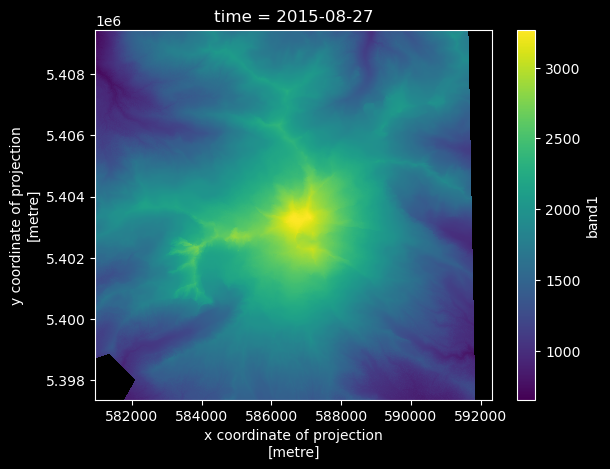

In [9]:
baker_ds['band1'].sel(time='2015-08-27').plot()

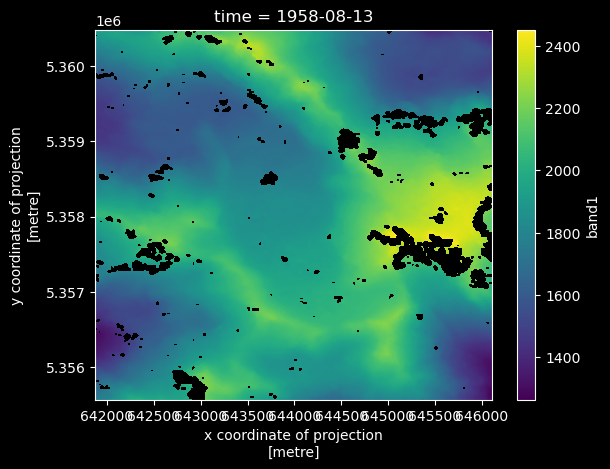

In [10]:
scg_ds['band1'].isel(time=0).plot()

### Plot bounds on interactive map

In [8]:
baker_gdf = tools.bounds2polygon(*baker_ds.rio.bounds(),baker_ds.rio.crs)
baker_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
               attr='Google')

In [9]:
scg_gdf = tools.bounds2polygon(*scg_ds.rio.bounds(),scg_ds.rio.crs)
scg_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
               attr='Google')

### Select sample points on map


In [10]:
# tools.select_points_on_map(baker_gdf, 
#                            output_file_name = 'baker_points.geojson')

# tools.select_points_on_map(scg_gdf, 
#                            output_file_name = 'scg_points.geojson')

### Load sample points

In [9]:
scg_points_gdf = gpd.read_file('scg_points.geojson')
scg_points_gdf.explore()

### Plot points on count and standard deviation map

In [18]:
points = tools.extract_linestring_coords(scg_points_gdf.to_crs(scg_ds.rio.crs)['geometry'][0])
count_da = scg_ds['band1'].count(axis=0).compute()
std_da = scg_ds['band1'].std(axis=0).compute()

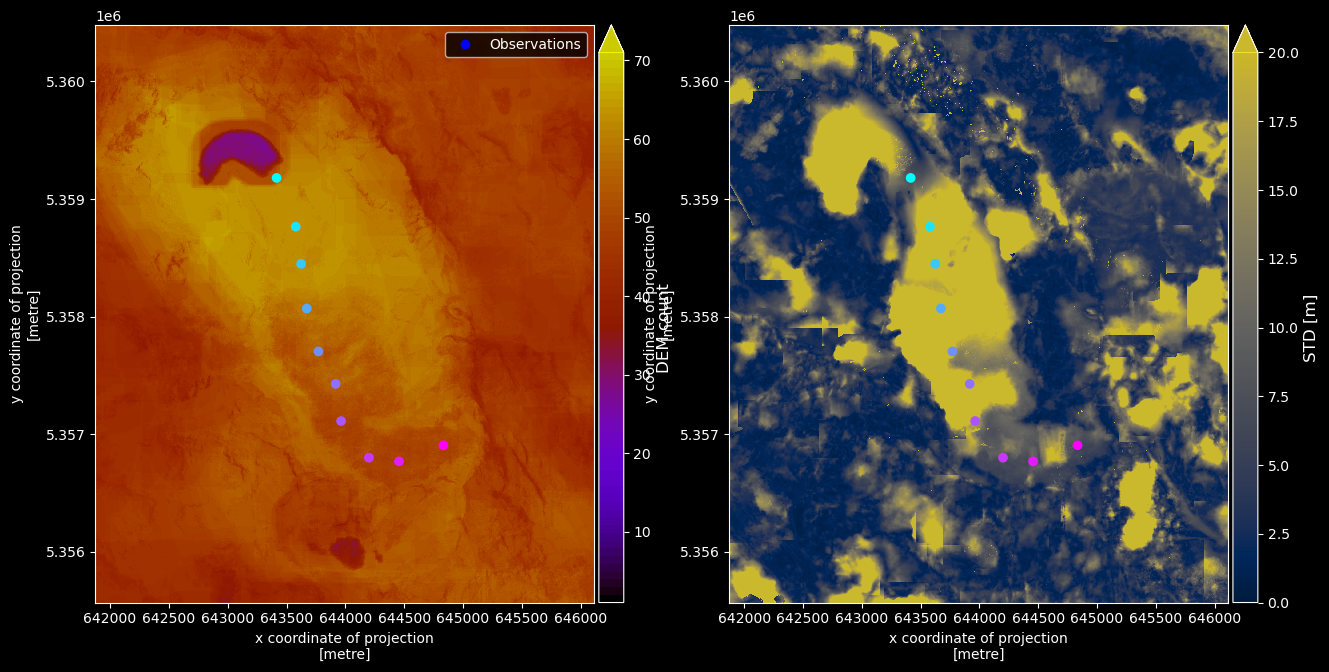

In [24]:
tools.xr_plot_count_std_glacier(count_da,
                                std_da,
                                points=points,
                                points_cmap = 'cool',
                                alpha = 0.8,
                                count_vmax=len(scg_ds.time))

### Extract time series at points

In [21]:
time_series_data, time_stamps = tools.get_test_time_series(scg_ds['band1'], points)

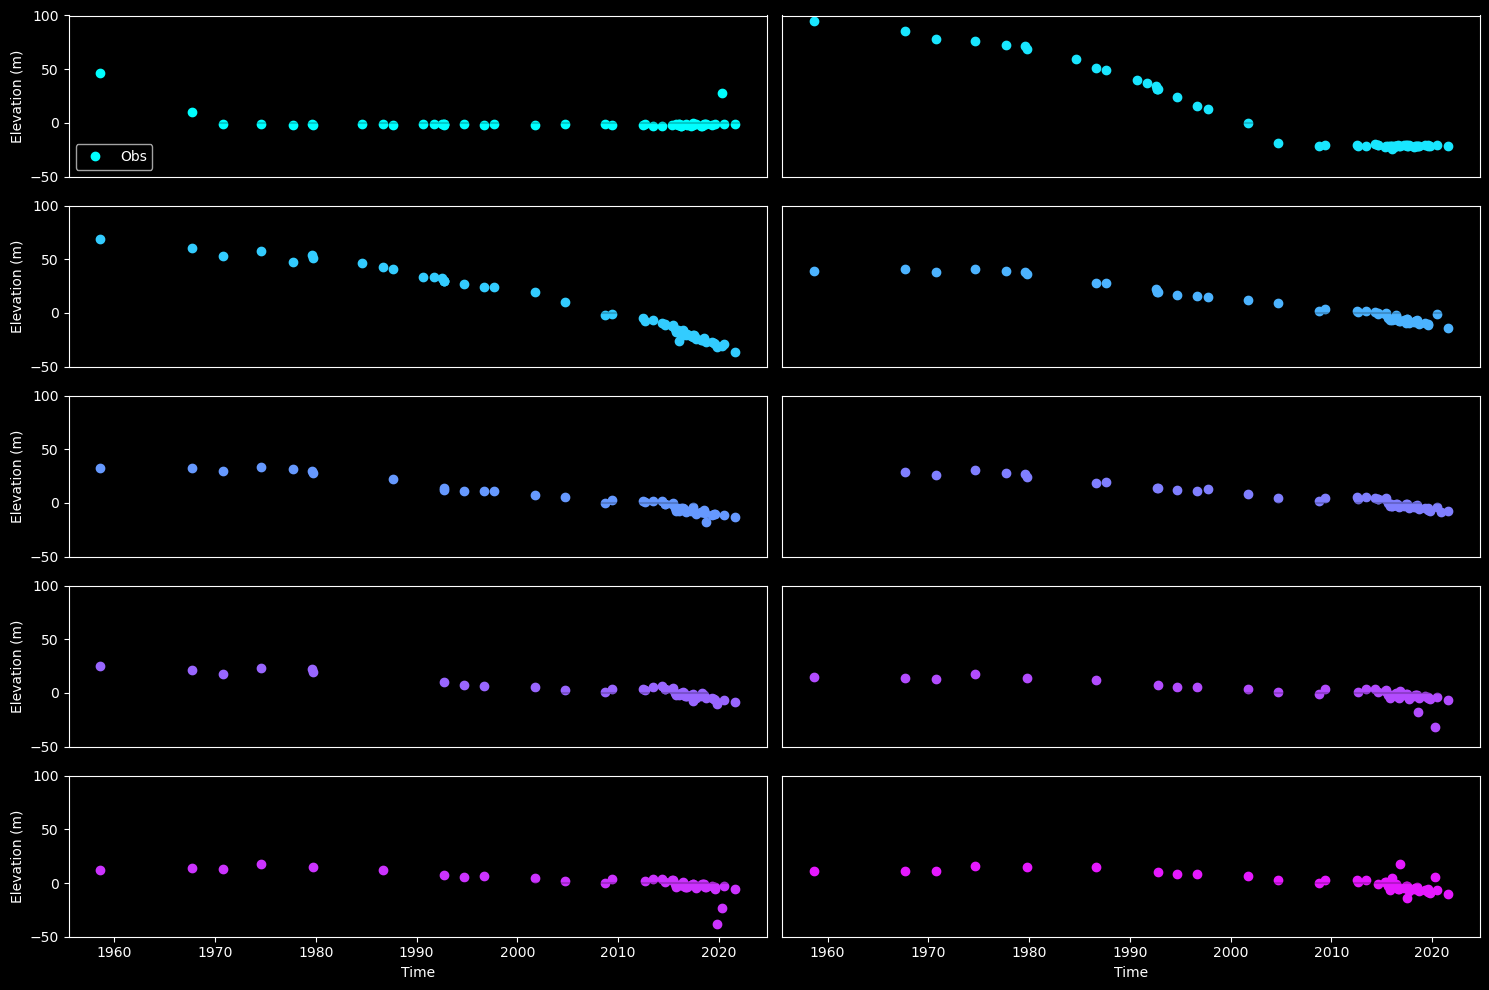

In [22]:
tools.plot_time_series_gallery(time_stamps,
                         time_series_data,
                         ylim=(-50,100),
                         sharey=True,
                         cmap='cool',
                        )

### Fit GP and plot

(in progress)

## Additional examples

For examples of computations along the time axis see [examples in GTSA library](https://github.com/friedrichknuth/gtsa/blob/main/notebooks/processing/02_time_series_computations.ipynb).

## References

[Historical HSfM DEMs](https://zenodo.org/records/7297154)

Knuth, Friedrich, David Shean, Shashank Bhushan, Eli Schwat, Oleg Alexandrov, Christopher McNeil, Amaury Dehecq, Caitlyn Florentine, and Shad O’Neel. "Historical Structure from Motion (HSfM): Automated processing of historical aerial photographs for long-term topographic change analysis." Remote Sensing of Environment 285 (2023): 113379.

[USGS Geodetic DEMs](https://alaska.usgs.gov/products/data/glaciers/benchmark_geodetic.php)

McNeil, C.J., Florentine, C.E., Bright, V.A.L., Fahey, M.J., McCann, E., Larsen, C.F., Thoms, E.E., Shean, D.E., McKeon, L.A., March, R.S., Keller, W., Whorton, E.N., O'Neel, S., Baker, E.H., Sass, L.C. and Bollen, K.E. 2019, Geodetic data for USGS benchmark glaciers: orthophotos, digital elevation models, glacier boundaries and surveyed positions (ver 3.0, August 2022): U.S. Geological Survey data release, https://doi.org/10.5066/P9R8BP3K.

[EarthDEM Strips](https://www.pgc.umn.edu/data/earthdem/)

DEM Strips:  Porter, Claire; Howat, Ian; Husby, Erik; Noh, Myoung-Jon; Khuvis, Samuel; Danish, Evan; Tomko, Karen; Gardiner, Judith; Negrete, Adelaide; Yadav, Bidhyananda; Klassen, James; Kelleher, Cole; Cloutier, Michael; Bakker, Jesse; Enos, Jeremy; Arnold, Galen; Bauer, Greg; Morin, Paul, 2022, “EarthDEM – Strips, Version 1”, https://doi.org/10.7910/DVN/LHE9O7, Harvard Dataverse, V1